<a href="https://colab.research.google.com/github/vorobieva/Day3_binderDesign/blob/main/de_novo_design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!--NOTEBOOK_HEADER-->
*This notebook contains material from [PyRosetta](https://RosettaCommons.github.io/PyRosetta.notebooks);
content is available [on Github](https://github.com/RosettaCommons/PyRosetta.notebooks.git).* This notebook was developed based on the original notebook by Thomas Guiziou (thomas.guiziou@vub.be).

# Design of de novo minibinder to the RBD of Sars-cov-2
# RFdiffusion, ProteinMPNN, ColabFold


## Design Project:
- The goal is to design a binder to the SARS-COV2 RBD (Receptor Binding Protein) that shares the same binding interface as the RBD natural ligand - the human ACEII receptor. The designed binder can then act as a competitive inhibitor of SarsCov2 binding and invasion of human cells.

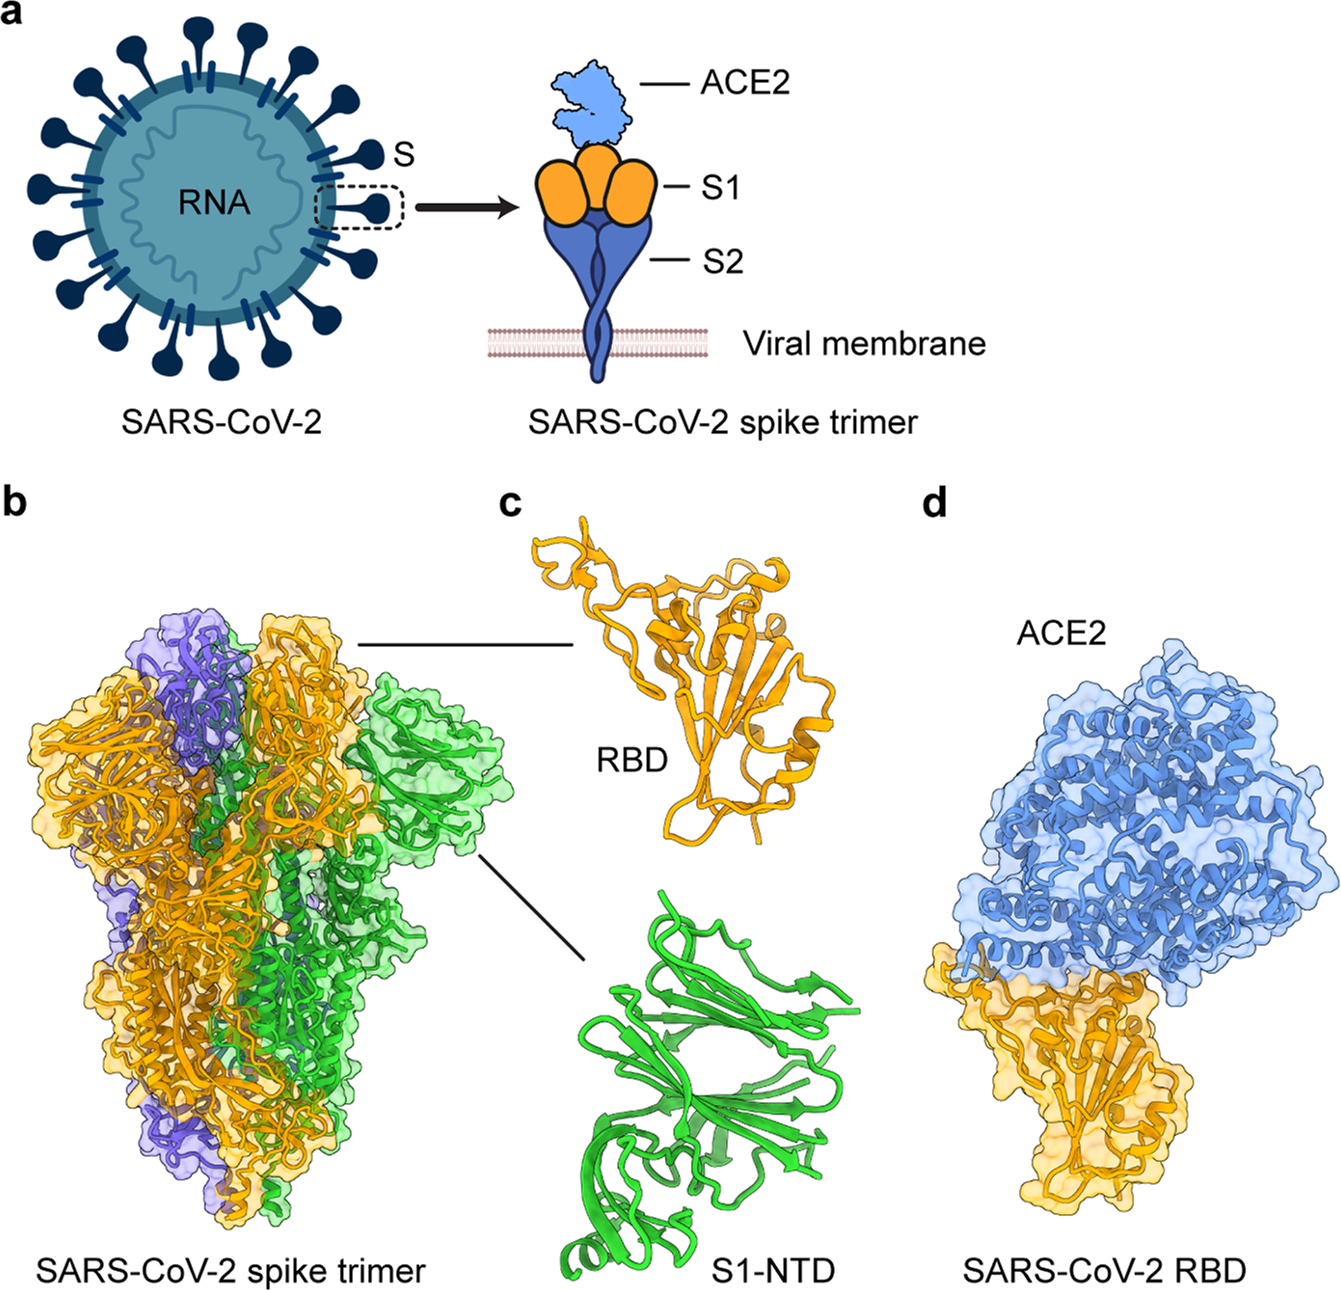

- Starting from the 7BH9 structure, we will use two strategies to design binders. We will design (i) a _de novo_ binder and (ii) we will strart from the RBD binding peptide and design a scaffold around it.

**De non designed interface**
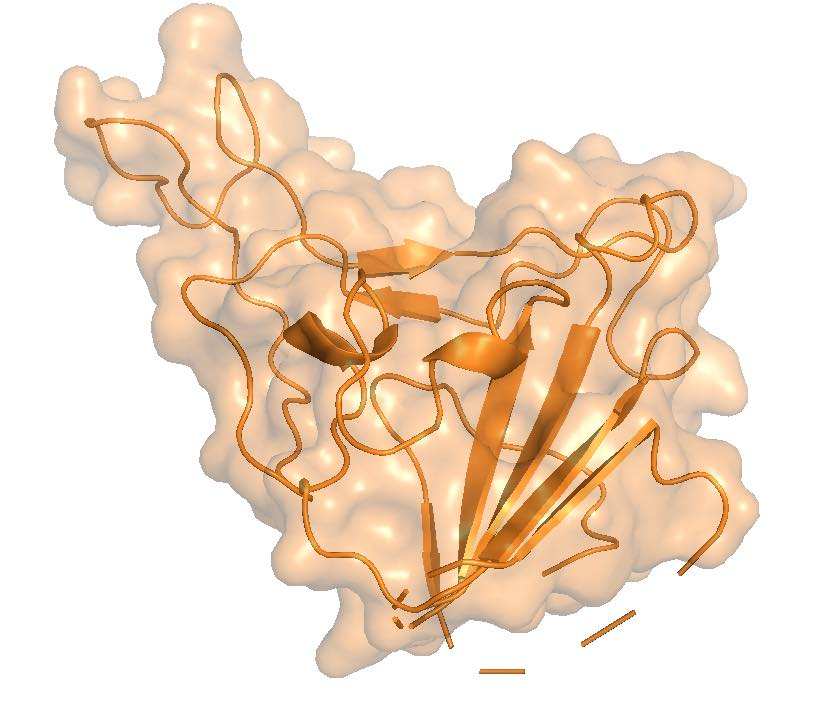

**Scaffolding the native binding motif in a smaller and better behaved protein**

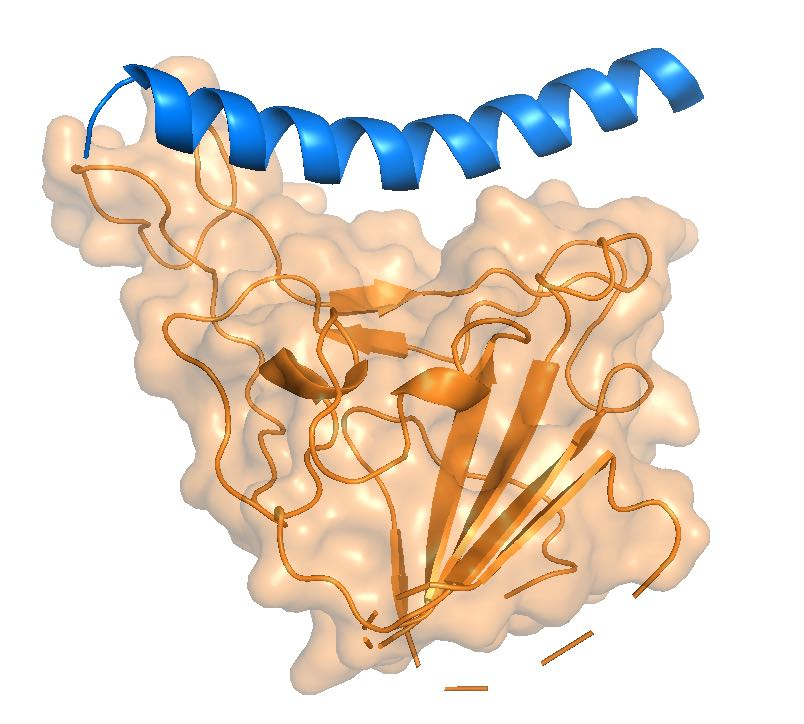

- The design pipeline starts with design of the backbones using **RFdiffusion**, then we design the sequence using **ProteinMPNN** and pick sequences using **ColabFold** with Initial Guess with single sequence mode.

## Import modules and packages:

### <u>Module to load for this exercise</u>
- matplotlib
- Seaborn
- Pyrosetta
- RFDiffusion
- ProteinMPNN

In [ ]:
#@title Install and import pyrosetta - the molecular modelling software
!pip install pyrosettacolabsetup
import pyrosettacolabsetup; pyrosettacolabsetup.install_pyrosetta()
import pyrosetta; pyrosetta.init()

In [ ]:
#@title Import the necessary Python modules
!pip install py3Dmol
from google.colab import files
import os
import glob
import numpy as np
import logging
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from copy import copy
import json, warnings

%matplotlib inline

In [ ]:
#@title setup **RFdiffusion** (~3min)
%%time
import os, time, signal
import sys, random, string, re
if not os.path.isdir("params"):
  os.system("apt-get install aria2")
  os.system("mkdir params")
  # send param download into background
  os.system("(\
  aria2c -q -x 16 https://files.ipd.uw.edu/krypton/schedules.zip; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/6f5902ac237024bdd0c176cb93063dc4/Base_ckpt.pt; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/e29311f6f1bf1af907f9ef9f44b8328b/Complex_base_ckpt.pt; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/f572d396fae9206628714fb2ce00f72e/Complex_beta_ckpt.pt; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar; \
  tar -xf alphafold_params_2022-12-06.tar -C params; \
  touch params/done.txt) &")

if not os.path.isdir("RFdiffusion"):
  print("installing RFdiffusion...")
  os.system("git clone https://github.com/sokrypton/RFdiffusion.git")
  os.system("pip install jedi omegaconf hydra-core icecream pyrsistent pynvml decorator")
  os.system("pip install git+https://github.com/NVIDIA/dllogger#egg=dllogger")
  # 17Mar2024: adding --no-dependencies to avoid installing nvidia-cuda-* dependencies
  os.system("pip install --no-dependencies dgl==2.0.0 -f https://data.dgl.ai/wheels/cu121/repo.html")
  os.system("pip install --no-dependencies e3nn==0.5.5 opt_einsum_fx")
  os.system("cd RFdiffusion/env/SE3Transformer; pip install .")
  os.system("wget -qnc https://files.ipd.uw.edu/krypton/ananas")
  os.system("chmod +x ananas")

if not os.path.isdir("colabdesign"):
  print("installing ColabDesign...")
  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")

if not os.path.isdir("RFdiffusion/models"):
  print("downloading RFdiffusion params...")
  os.system("mkdir RFdiffusion/models")
  models = ["Base_ckpt.pt","Complex_base_ckpt.pt","Complex_beta_ckpt.pt"]
  for m in models:
    while os.path.isfile(f"{m}.aria2"):
      time.sleep(5)
  os.system(f"mv {' '.join(models)} RFdiffusion/models")
  os.system("unzip schedules.zip; rm schedules.zip")

if 'RFdiffusion' not in sys.path:
  os.environ["DGLBACKEND"] = "pytorch"
  sys.path.append('RFdiffusion')

from google.colab import files
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
import py3Dmol

from inference.utils import parse_pdb
from colabdesign.rf.utils import get_ca
from colabdesign.rf.utils import fix_contigs, fix_partial_contigs, fix_pdb, sym_it
from colabdesign.shared.protein import pdb_to_string
from colabdesign.shared.plot import plot_pseudo_3D

def get_pdb(pdb_code=None):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    if not os.path.isfile(f"{pdb_code}.pdb1"):
      os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.pdb1.gz")
      os.system(f"gunzip {pdb_code}.pdb1.gz")
    return f"{pdb_code}.pdb1"
  else:
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v3.pdb")
    return f"{pdb_code}"

def run_ananas(pdb_str, path, sym=None):
  pdb_filename = f"outputs/{path}/ananas_input.pdb"
  out_filename = f"outputs/{path}/ananas.json"
  with open(pdb_filename,"w") as handle:
    handle.write(pdb_str)

  cmd = f"./ananas {pdb_filename} -u -j {out_filename}"
  if sym is None: os.system(cmd)
  else: os.system(f"{cmd} {sym}")

  # parse results
  try:
    out = json.loads(open(out_filename,"r").read())
    results,AU = out[0], out[-1]["AU"]
    group = AU["group"]
    chains = AU["chain names"]
    rmsd = results["Average_RMSD"]
    print(f"AnAnaS detected {group} symmetry at RMSD:{rmsd:.3}")

    C = np.array(results['transforms'][0]['CENTER'])
    A = [np.array(t["AXIS"]) for t in results['transforms']]

    # apply symmetry and filter to the asymmetric unit
    new_lines = []
    for line in pdb_str.split("\n"):
      if line.startswith("ATOM"):
        chain = line[21:22]
        if chain in chains:
          x = np.array([float(line[i:(i+8)]) for i in [30,38,46]])
          if group[0] == "c":
            x = sym_it(x,C,A[0])
          if group[0] == "d":
            x = sym_it(x,C,A[1],A[0])
          coord_str = "".join(["{:8.3f}".format(a) for a in x])
          new_lines.append(line[:30]+coord_str+line[54:])
      else:
        new_lines.append(line)
    return results, "\n".join(new_lines)

  except:
    return None, pdb_str

def run(command, steps, num_designs=1, visual="none"):

  def run_command_and_get_pid(command):
    pid_file = '/dev/shm/pid'
    os.system(f'nohup {command} & echo $! > {pid_file}')
    with open(pid_file, 'r') as f:
      pid = int(f.read().strip())
    os.remove(pid_file)
    return pid
  def is_process_running(pid):
    try:
      os.kill(pid, 0)
    except OSError:
      return False
    else:
      return True

  run_output = widgets.Output()
  progress = widgets.FloatProgress(min=0, max=1, description='running', bar_style='info')
  display(widgets.VBox([progress, run_output]))

  # clear previous run
  for n in range(steps):
    if os.path.isfile(f"/dev/shm/{n}.pdb"):
      os.remove(f"/dev/shm/{n}.pdb")

  pid = run_command_and_get_pid(command)
  try:
    fail = False
    for _ in range(num_designs):

      # for each step check if output generated
      for n in range(steps):
        wait = True
        while wait and not fail:
          time.sleep(0.1)
          if os.path.isfile(f"/dev/shm/{n}.pdb"):
            pdb_str = open(f"/dev/shm/{n}.pdb").read()
            if pdb_str[-3:] == "TER":
              wait = False
            elif not is_process_running(pid):
              fail = True
          elif not is_process_running(pid):
            fail = True

        if fail:
          progress.bar_style = 'danger'
          progress.description = "failed"
          break

        else:
          progress.value = (n+1) / steps
          if visual != "none":
            with run_output:
              run_output.clear_output(wait=True)
              if visual == "image":
                xyz, bfact = get_ca(f"/dev/shm/{n}.pdb", get_bfact=True)
                fig = plt.figure()
                fig.set_dpi(100);fig.set_figwidth(6);fig.set_figheight(6)
                ax1 = fig.add_subplot(111);ax1.set_xticks([]);ax1.set_yticks([])
                plot_pseudo_3D(xyz, c=bfact, cmin=0.5, cmax=0.9, ax=ax1)
                plt.show()
              if visual == "interactive":
                view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
                view.addModel(pdb_str,'pdb')
                view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
                view.zoomTo()
                view.show()
        if os.path.exists(f"/dev/shm/{n}.pdb"):
          os.remove(f"/dev/shm/{n}.pdb")
      if fail:
        progress.bar_style = 'danger'
        progress.description = "failed"
        break

    while is_process_running(pid):
      time.sleep(0.1)

  except KeyboardInterrupt:
    os.kill(pid, signal.SIGTERM)
    progress.bar_style = 'danger'
    progress.description = "stopped"

def run_diffusion(contigs, path, pdb=None, iterations=50,
                  symmetry="none", order=1, hotspot=None,
                  chains=None, add_potential=False, partial_T="auto",
                  num_designs=1, use_beta_model=False, visual="none"):

  full_path = f"{pathWD}outputs/{path}"
  os.makedirs(full_path, exist_ok=True)
  opts = [f"inference.output_prefix={full_path}",
          f"inference.num_designs={num_designs}"]

  if chains == "": chains = None

  # determine symmetry type
  if symmetry in ["auto","cyclic","dihedral"]:
    if symmetry == "auto":
      sym, copies = None, 1
    else:
      sym, copies = {"cyclic":(f"c{order}",order),
                     "dihedral":(f"d{order}",order*2)}[symmetry]
  else:
    symmetry = None
    sym, copies = None, 1

  # determine mode
  contigs = contigs.replace(","," ").replace(":"," ").split()
  is_fixed, is_free = False, False
  fixed_chains = []
  for contig in contigs:
    for x in contig.split("/"):
      a = x.split("-")[0]
      if a[0].isalpha():
        is_fixed = True
        if a[0] not in fixed_chains:
          fixed_chains.append(a[0])
      if a.isnumeric():
        is_free = True
  if len(contigs) == 0 or not is_free:
    mode = "partial"
  elif is_fixed:
    mode = "fixed"
  else:
    mode = "free"

  # fix input contigs
  if mode in ["partial","fixed"]:
    pdb_str = pdb_to_string(get_pdb(pdb), chains=chains)
    if symmetry == "auto":
      a, pdb_str = run_ananas(pdb_str, path)
      if a is None:
        print(f'ERROR: no symmetry detected')
        symmetry = None
        sym, copies = None, 1
      else:
        if a["group"][0] == "c":
          symmetry = "cyclic"
          sym, copies = a["group"], int(a["group"][1:])
        elif a["group"][0] == "d":
          symmetry = "dihedral"
          sym, copies = a["group"], 2 * int(a["group"][1:])
        else:
          print(f'ERROR: the detected symmetry ({a["group"]}) not currently supported')
          symmetry = None
          sym, copies = None, 1

    elif mode == "fixed":
      pdb_str = pdb_to_string(pdb_str, chains=fixed_chains)

    pdb_filename = f"{full_path}/input.pdb"
    with open(pdb_filename, "w") as handle:
      handle.write(pdb_str)

    parsed_pdb = parse_pdb(pdb_filename)
    opts.append(f"inference.input_pdb={pdb_filename}")
    if mode in ["partial"]:
      if partial_T == "auto":
        iterations = int(80 * (iterations / 200))
      else:
        iterations = int(partial_T)
      opts.append(f"diffuser.partial_T={iterations}")
      contigs = fix_partial_contigs(contigs, parsed_pdb)
    else:
      opts.append(f"diffuser.T={iterations}")
      contigs = fix_contigs(contigs, parsed_pdb)
  else:
    opts.append(f"diffuser.T={iterations}")
    parsed_pdb = None
    contigs = fix_contigs(contigs, parsed_pdb)

  if hotspot is not None and hotspot != "":
    hotspot = ",".join(hotspot.replace(","," ").split())
    opts.append(f"ppi.hotspot_res='[{hotspot}]'")

  # setup symmetry
  if sym is not None:
    sym_opts = ["--config-name symmetry", f"inference.symmetry={sym}"]
    if add_potential:
      sym_opts += ["'potentials.guiding_potentials=[\"type:olig_contacts,weight_intra:1,weight_inter:0.1\"]'",
                   "potentials.olig_intra_all=True","potentials.olig_inter_all=True",
                   "potentials.guide_scale=2","potentials.guide_decay=quadratic"]
    opts = sym_opts + opts
    contigs = sum([contigs] * copies,[])

  opts.append(f"'contigmap.contigs=[{' '.join(contigs)}]'")
  opts += ["inference.dump_pdb=True","inference.dump_pdb_path='/dev/shm'"]
  if use_beta_model:
    opts += ["inference.ckpt_override_path=./RFdiffusion/models/Complex_beta_ckpt.pt"]

  print("mode:", mode)
  print("output:", full_path)
  print("contigs:", contigs)

  opts_str = " ".join(opts)
  cmd = f"./RFdiffusion/run_inference.py {opts_str}"
  print(cmd)

  # RUN
  run(cmd, iterations, num_designs, visual=visual)

  # fix pdbs
  for n in range(num_designs):
    pdbs = [f"{pathWD}outputs/traj/{path}_{n}_pX0_traj.pdb",
            f"{pathWD}outputs/traj/{path}_{n}_Xt-1_traj.pdb",
            f"{full_path}_{n}.pdb"]
    for pdb in pdbs:
      with open(pdb,"r") as handle: pdb_str = handle.read()
      with open(pdb,"w") as handle: handle.write(fix_pdb(pdb_str, contigs))

  return contigs, copies

In [ ]:
#@title Mount google drive
from google.colab import drive
drive.mount('/content/google_drive')
pathWD="/content/google_drive/MyDrive/Pavia_course/Day3_binderDesign/"

# RFdiffusion

### RFdiffusion has different parameters that are explained below:
- Here is an example command that we will run to generate the _de novo_ binder:

*run_inference.py inference.output_prefix={output_folder}/{output_prefix} \
    inference.input_pdb=input_RFdiffusion/7bh9_clean.pdb \
    inference.num_designs=1 \
    'contigmap.contigs="E603-730/0 90-120"' \
    'ppi.hotspot_res="E669,E671,E672,E689,E703,E705,E709,E712,E714,E716,E717,E718,E721"' \
    diffuser.T=25*

These parameters are explained as follow:
- **inference.output_prefix**: the prefix tag added to the output.
- **inference.num_designs**: the number of designs to generate.
- **inference.input_pdb**: the input PDB structure.
- **contigmap.contig**: The parameters that specify the length and number of protein chains to generate (see more tips to write contigs below).
    - E603-730: the residues from the input that will be included into the generate backbones and kept fixed ~RMSD <1 Å.
    - 0 : chain break.
    - 90-120 : The range of lengths the generated proteins can have (between 90 and 120 residues)
- **diffuser.T**: number of denoising step. 25 allows to reduce computing time.
- **ppi.hotspot_res**: The residues on the target where we want to bind to.

Now that you understand the parameters, let's produce designs de novo and by scaffolding the native binding motif.

*De novo design*
1. change *name* to *de_novo*
2. *contigs*: Keep residues 603-730 from the input structure (the RBD), then build a second protein chain between 90-120 residues long.
3. *pdb*: 7bh9_clean.pdb
4. *iterations*: 25
5. *hotspot*: "E669,E671,E672,E689,E703,E705,E709,E712,E714,E716,E717,E718,E721"
6. *num_designs*: 5


When the *de novo* model are ready, make the following modifications to run the motif scaffolding predictions:
1. change name to *scaffold*
2. *contigs*: 40-40/A3-25/40-40/0 E603-730
3. Hotspots: " "

In [ ]:
%%time
#@title run **RFdiffusion** to generate a backbone
name = "de_novo" #@param ["scaffold", "de_novo"]
contigs = "E603-730/0 90-120" #@param {type:"string"}
pdb = "7bh9_clean.pdb" #@param {type:"string"}
iterations = 25 #@param ["25", "50", "100", "150", "200"] {type:"raw"}
hotspot = "E669,E671,E672,E689,E703,E705,E709,E712,E714,E716,E717,E718,E721" #@param {type:"string"}
num_designs = 2 #@param ["1", "2", "5", "10", "15", "20"] {type:"raw"}
visual = "image" #@param ["none", "image", "interactive"]
#@markdown ---
#@markdown **advanced** settings
#@markdown ---
partial_T = "auto" # @param ["auto", "10", "20", "40", "60", "80"]
#@markdown - specify number of noising steps (only used for the partial diffusion protocol)
use_beta_model = False #@param {type:"boolean"}
#@markdown - if you are seeing lots of helices, switch to the "beta" params for a better SSE balance.

# determine where to save
input_pdb = pathWD+pdb
path = name
while os.path.exists(f"{pathWD}outputs/{path}_0.pdb"):
  path = name + "_" + ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))


#Adding these (secret) lines that overrides user input to avoid troubleshooting with distracted students during the workshop. Remove this bloc if neede.
if name == "de_novo":
  contigs = "E603-730/0 90-120"
  hotspot = "E669,E671,E672,E689,E703,E705,E709,E712,E714,E716,E717,E718,E721"
elif name == "scaffold":
  contigs = "40-40/A3-25/40-40/0 E603-730"
  hotspot = ""


flags = {"contigs":contigs,
         "pdb":input_pdb,
         "iterations":iterations,
         "hotspot":hotspot,
         "path":path,
         "num_designs":num_designs,
         "use_beta_model":use_beta_model,
         "visual":visual,
         "partial_T":partial_T}

for k,v in flags.items():
  if isinstance(v,str):
    flags[k] = v.replace("'","").replace('"','')

contigs, copies = run_diffusion(**flags)
print(contigs, copies)

In [ ]:
#@title Display 3D structure {run: "auto"}
path = "scaffold" #@param ["scaffold", "de_novo"]
animate = "none" #@param ["none", "movie", "interactive"]
color = "chain" #@param ["rainbow", "chain", "plddt"]
denoise = True
dpi = 100 #@param ["100", "200", "400"] {type:"raw"}
from colabdesign.shared.plot import pymol_color_list
from colabdesign.rf.utils import get_ca, get_Ls, make_animation
from string import ascii_uppercase,ascii_lowercase
alphabet_list = list(ascii_uppercase+ascii_lowercase)

def plot_pdb(num=0):
  if denoise:
    pdb_traj = f"{pathWD}outputs/traj/{path}_{num}_pX0_traj.pdb"
  else:
    pdb_traj = f"{pathWD}outputs/traj/{path}_{num}_Xt-1_traj.pdb"
  if animate in ["none","interactive"]:
    hbondCutoff = 4.0
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
    if animate == "interactive":
      pdb_str = open(pdb_traj,'r').read()
      view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
    else:
      pdb = f"{pathWD}outputs/{path}_{num}.pdb"
      pdb_str = open(pdb,'r').read()
      view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
    if color == "rainbow":
      view.setStyle({'cartoon': {'color':'spectrum'}})
    elif color == "chain":
      for n,chain,c in zip(range(2),
                              alphabet_list,
                              pymol_color_list):
          view.setStyle({'chain':chain},{'cartoon': {'color':c}})
    else:
      view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
    view.zoomTo()
    if animate == "interactive":
      view.animate({'loop': 'backAndForth'})
    view.show()
  else:
    Ls = get_Ls(contigs)
    xyz, bfact = get_ca(pdb_traj, get_bfact=True)
    xyz = xyz.reshape((-1,sum(Ls),3))[::-1]
    bfact = bfact.reshape((-1,sum(Ls)))[::-1]
    if color == "chain":
      display(HTML(make_animation(xyz, Ls=Ls, dpi=dpi, ref=-1)))
    elif color == "rainbow":
      display(HTML(make_animation(xyz, dpi=dpi, ref=-1)))
    else:
      display(HTML(make_animation(xyz, plddt=bfact*100, dpi=dpi, ref=-1)))

num_designs = len(glob.glob(pathWD+"outputs/"+path+"_*.pdb"))
if num_designs > 1:
  output = widgets.Output()
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb(change['new'])
  dropdown = widgets.Dropdown(
      options=[(f'{k}',k) for k in range(num_designs)],
      value=0, description='design:',
  )
  dropdown.observe(on_change)
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb(dropdown.value)
else:
  plot_pdb()

TIP: go to the output/traj folder to find a PDB showing different snapshots of the diffusion trajectory!!

In [ ]:
%%time
#@title run **ProteinMPNN** to generate a sequence and **AlphaFold** to validate
#@markdown ProteinMPNN Settings
path = "de_novo" #@param ["scaffold", "de_novo"]
num_seqs = 2 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
mpnn_sampling_temp = 0.1 #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5", "1.0"] {type:"raw"}
rm_aa = "C" #@param {type:"string"}
use_solubleMPNN = False #@param {type:"boolean"}
contigs = "E603-730/0 90-120" #@param {type:"string"}
num_designs = 5 #@param ["1", "2", "5", "10", "15", "20"] {type:"raw"}
#@markdown - `mpnn_sampling_temp` - control diversity of sampled sequences. (higher = more diverse).
#@markdown - `rm_aa='C'` - do not use [C]ysteines.
#@markdown - `use_solubleMPNN` - use weights trained only on soluble proteins. See [preprint](https://www.biorxiv.org/content/10.1101/2023.05.09.540044v2).
#@markdown
#@markdown AlphaFold Settings
initial_guess = True #@param {type:"boolean"}
#@markdown - soft initialization with desired coordinates, see [paper](https://www.nature.com/articles/s41467-023-38328-5).
num_recycles = 3 #@param ["0", "1", "2", "3", "6", "12"] {type:"raw"}
#@markdown - for **binder** design, we recommend `initial_guess=True num_recycles=3`
use_multimer = False #@param {type:"boolean"}
#@markdown - `use_multimer` - use AlphaFold Multimer v3 params for prediction.

if not os.path.isfile("params/done.txt"):
  print("downloading AlphaFold params...")
  while not os.path.isfile("params/done.txt"):
    time.sleep(5)


#Adding these (secret) lines that overrides user input to avoid troubleshooting with distracted students during the workshop. Remove this bloc if neede.
if name == "de_novo":
  contigs = "E603-730/0 90-120"
elif name == "scaffold":
  contigs = "40-40/A3-25/40-40/0 E603-730"

contigs_str = contigs.replace(" ", ":") #":".join(contigs)
opts = [f"--pdb={pathWD}outputs/{path}_1.pdb",
        f"--loc={pathWD}outputs/{path}",
        f"--contig={contigs_str}",
        f"--copies=1",
        f"--num_seqs={num_seqs}",
        f"--num_recycles={num_recycles}",
        f"--rm_aa={rm_aa}",
        f"--mpnn_sampling_temp={mpnn_sampling_temp}",
        f"--num_designs={num_designs}"]
if initial_guess: opts.append("--initial_guess")
if use_multimer: opts.append("--use_multimer")
if use_solubleMPNN: opts.append("--use_soluble")
opts = ' '.join(opts)
!python colabdesign/rf/designability_test.py {opts}

#Reminder about the metrics computed here

**pLDDT**: confidence score of AlphaFold structure prediction. For de novo designed proteins, high pLDDT suggest higher chance of folding in the lab.

**pAE**: Confidence of the prediction of the position of one subunit relative to the second subunit in the complex

**pTm**: predicted Tm score (a structure superposition test). If pTm is greater than 0.5, the predicted structure of the binder is the same topology as the designed structure. The closer to 1.0, the greater the ressemblance between the predicted and designed structures.

**RMSD**: Root Mean Square Deviation between the predicted and the designed structures, in Angstrom. The lowest the RMSD, the more similar are the two structures.

In [ ]:
#@title Visualizaing the distribution of pLDDT, pAE and RMSD scores

dnovo = pd.read_csv(pathWD+"outputs/de_novo/mpnn_results.csv", header=0)
dscaffold = pd.read_csv(pathWD+"outputs/scaffold/mpnn_results.csv", header=0)

In [ ]:
#@title De novo designed interfaces

fig,axs = plt.subplots(nrows=2,ncols=2,sharex=False,sharey=False)
sns.histplot(data=dnovo, x="plddt", stat="probability", ax=axs[0,0])
sns.histplot(data=dnovo, x="i_ptm", stat="probability", ax=axs[0,1])
sns.histplot(data=dnovo, x="i_pae", stat="probability", ax=axs[1,0])
sns.histplot(data=dnovo, x="rmsd", stat="probability", ax=axs[1,1])
axs[0, 0].set_title('pLDDT')
axs[0, 1].set_title('pTM')
axs[1, 0].set_title('pAE')
axs[1, 1].set_title('RMSD')
axs[0, 0].set(ylim=(0, 1), xlim=(0, 1))
axs[1, 0].set(ylim=(0, 1), xlim=(0, 30))
axs[0, 1].set(ylim=(0, 1), xlim=(0, 1))
axs[1, 1].set(ylim=(0, 1), xlim=(0, 60))
fig.tight_layout()

In [ ]:
#@title Motif scaffolding interfaces

fig,axs = plt.subplots(nrows=2,ncols=2,sharex=False,sharey=False)
sns.histplot(data=dscaffold, x="plddt", stat="probability", ax=axs[0,0])
sns.histplot(data=dscaffold, x="ptm", stat="probability", ax=axs[0,1])
sns.histplot(data=dscaffold, x="pae", stat="probability", ax=axs[1,0])
sns.histplot(data=dscaffold, x="rmsd", stat="probability", ax=axs[1,1])
axs[0, 0].set_title('pLDDT')
axs[0, 1].set_title('pTM')
axs[1, 0].set_title('pAE')
axs[1, 1].set_title('RMSD')
axs[0, 0].set(ylim=(0, 1), xlim=(0, 1))
axs[1, 0].set(ylim=(0, 1), xlim=(0, 30))
axs[0, 1].set(ylim=(0, 1), xlim=(0, 1))
axs[1, 1].set(ylim=(0, 1), xlim=(0, 60))
fig.tight_layout()

In [ ]:
#@title Computing radii of giration

def calculate_rg(folder):
    dataset = []
    sf = pyrosetta.ScoreFunction()
    sf.set_weight(pyrosetta.rosetta.core.scoring.ScoreType(0).rg,1.0)

    for model in glob.glob(f"{pathWD}outputs/{folder}/best_design*.pdb"):
        pose = pyrosetta.pose_from_pdb(model)

        sf.setup_for_scoring(pose)
        rg = sf(pose)
        dataset.append(rg)
    return dataset

rg_denovo = calculate_rg("de_novo")
rg_scaffold = calculate_rg("scaffold")

fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True)
sns.histplot(data=rg_denovo, ax=ax1, stat="probability")
sns.histplot(data=rg_scaffold, ax=ax2, stat="probability")
ax1.set_title('De novo')
ax2.set_title('Scaffold')
ax1.set(xlim=(10, 30))

In [ ]:
%%time
#@title Relax, calculate and print binding free energy of the best design in its category
#@markdown Pyrosetta Settings
path = "de_novo" #@param ["scaffold", "de_novo"]

def relax(pose):
  relaxPose = pose.clone()
  xml = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string("""
    <ROSETTASCRIPTS>
        <SCOREFXNS>
        <ScoreFunction name="SFX1" weights="ref2015_cart">
           <Reweight scoretype="coordinate_constraint" weight="1.0"/>
        </ScoreFunction>
        </SCOREFXNS>
        <RESIDUE_SELECTORS>
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
        </TASKOPERATIONS>
        <FILTERS>
        </FILTERS>
        <MOVERS>
           <AtomCoordinateCstMover name="coord_cst" />
           <FastRelax name="relax" cartesian="true" scorefxn="SFX1" />
        </MOVERS>
        <APPLY_TO_POSE/>
        <PROTOCOLS>
           <Add mover= "coord_cst"/>
           <Add mover="relax" />
        </PROTOCOLS>
    </ROSETTASCRIPTS>
    """).get_mover("ParsedProtocol")
  xml.apply(relaxPose)
  return(relaxPose)

def unbind(pose, partners):
    STEP_SIZE = 100
    JUMP = 1
    pyrosetta.rosetta.protocols.docking.setup_foldtree(pose, partners, pyrosetta.Vector1([-1,-1,-1]))
    trans_mover = pyrosetta.rosetta.protocols.rigid.RigidBodyTransMover(pose,JUMP)
    trans_mover.step_size(STEP_SIZE)
    trans_mover.apply(pose)

def create_dataset(folder):
    scorefxn = pyrosetta.get_score_function()
    pose = pyrosetta.pose_from_pdb(f"{pathWD}outputs/{folder}/best.pdb")
    relaxP = relax(pose)
    relaxP.dump_pdb(f"{pathWD}outputs/{folder}/best_relaxed.pdb")

    bound_score = scorefxn(relaxP)
    original = relaxP.clone()
    unbind(original, "A_B")
    unbound_score = scorefxn(original)
    print('binding dG', bound_score - unbound_score, 'Rosetta Energy Units (REU)')
    return(bound_score - unbound_score)

binding_energy = create_dataset(path)

Results motif scaffolding binding dG -56.36488378013087 (REU)

Results de novo design binding dG -2.328850125127701 (REU)

**Instructions**
---
---

Use `contigs` to define continious chains. Use a `:` to define multiple contigs and a `/` to define mutliple segments within a contig.
For example:

**unconditional**
- `contigs='100'` - diffuse **monomer** of length 100
- `contigs='50:100'` - diffuse **hetero-oligomer** of lengths 50 and 100
- `contigs='50'` `symmetry='cyclic'` `order=2` - make two copies of the defined contig(s) and add a symmetry constraint, for **homo-oligomeric** diffusion.

**binder design**
- `contigs='A:50'` `pdb='4N5T'` - diffuse a **binder** of length 50 to chain A of defined PDB.
- `contigs='E6-155:70-100'` `pdb='5KQV'` `hotspot='E64,E88,E96'` - diffuse a **binder** of length 70 to 100 (sampled randomly) to chain E and defined hotspot(s).

**motif scaffolding**
 - `contigs='40/A163-181/40'` `pdb='5TPN'`
 - `contigs='A3-30/36/A33-68'` `pdb='6MRR'` - diffuse a loop of length 36 between two segments of defined PDB ranges.

**partial diffusion**
- `contigs=''` `pdb='6MRR'` - noise all coordinates
- `contigs='A1-10'` `pdb='6MRR'` - keep first 10 positions fixed, noise the rest
- `contigs='A'` `pdb='1SSC'` - fix chain A, noise the rest

*hints and tips*
- `pdb=''` leave blank to get an upload prompt
- `contigs='50-100'` use dash to specify a range of lengths to sample from